In [1]:
#Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)

In [2]:
#Loading the Dataset
df = pd.read_csv("../results/outputs/processed_stroke_dataset.csv")

In [3]:
#Displaying Top 5 rows from the dataset
df.head()

,Age,Gender,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Family History of Stroke,Stress Levels,Diagnosis,...,Confusion,Difficulty Speaking,Dizziness,Headache,Loss of Balance,Numbness,Seizures,Severe Fatigue,Unknown,Weakness
0,0.527778,0,0,1,0.506500,0.294518,0,1,0.348,1,...,0,1,0,1,0,0,0,0,0,0
1,0.861111,0,0,0,0.883786,0.702681,0,0,0.173,1,...,1,0,1,1,1,0,0,0,0,0
2,0.111111,0,1,1,0.921429,0.212485,0,1,0.731,1,...,0,0,1,0,0,0,1,0,0,0
3,0.763889,0,0,0,0.894929,0.499800,0,0,0.535,0,...,1,0,0,1,0,0,1,1,0,0
4,0.458333,0,1,1,0.838143,0.562225,0,1,0.684,1,...,0,1,0,0,0,0,0,0,0,0


In [4]:
#Splitting the dataset into features (X) and target (y)
#Independant variables = features & dependant variables = target
X = df.drop('Diagnosis', axis = 1)
y = df['Diagnosis']

In [5]:
#Splitting into training (80%) & testing (20%)
X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

print("Training set size:\t", X_train.shape)
print("Testing set size:\t", X_test.shape)

Training set size:	 (12000, 50)
Testing set size:	 (3000, 50)


In [6]:
#Defining the scalers & kernel types we'll loop over
#Done to not write repetative code
scalers = {
    'StandardScaler' : StandardScaler(),
    'MinMaxScaler' : MinMaxScaler()
}
kernels = ['linear', 'rbf']

In [7]:
#Storing evaluation results for each configuration
results = []

In [8]:
#Defining parameter grid to be passed into GridSearchCV
param_grid = {
    'C' : [0.1, 1, 10],
    'gamma' : ['scale', 0.01, 0.1]
}


Training SVM (linear kernel) with StandardScaler...
Best parameters for Linear (StandardScaler): {'C': 1}


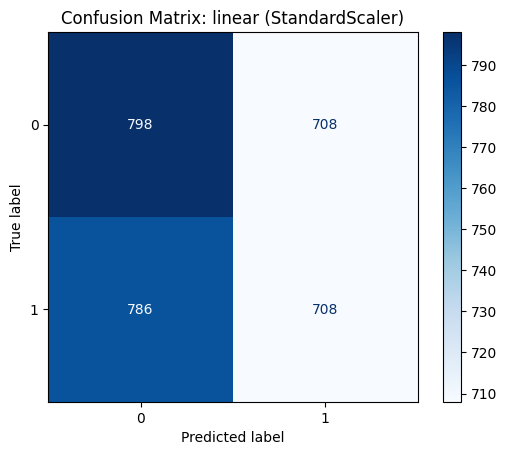

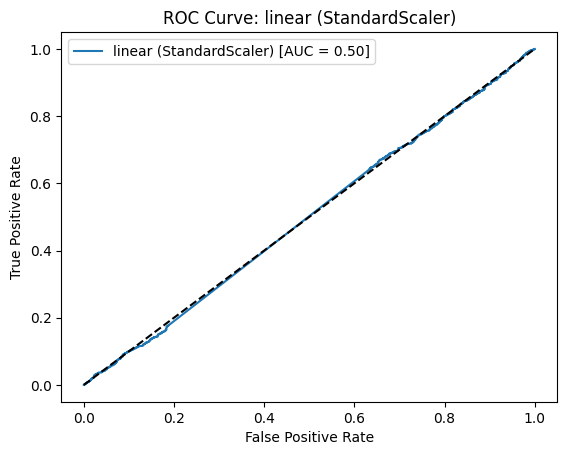


Training SVM (rbf kernel) with StandardScaler...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for RBF (StandardScaler): {'C': 10, 'gamma': 'scale'}


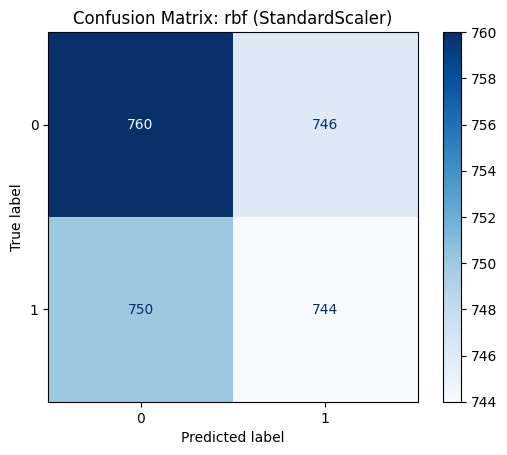

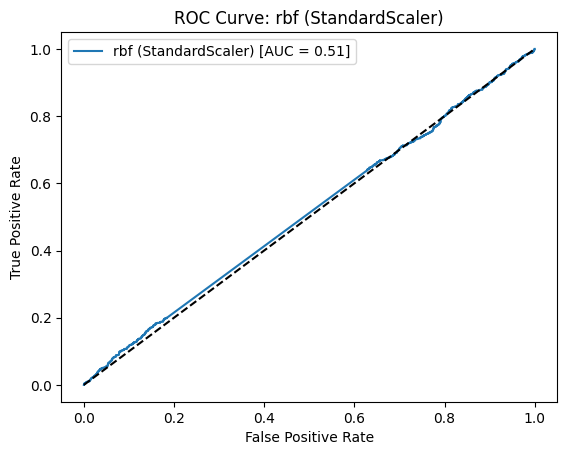


Training SVM (linear kernel) with MinMaxScaler...
Best parameters for Linear (MinMaxScaler): {'C': 1}


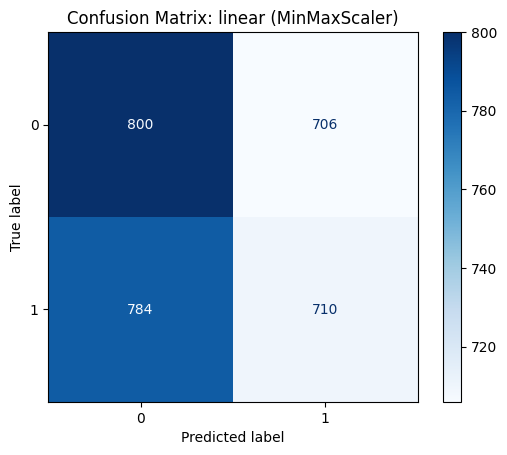

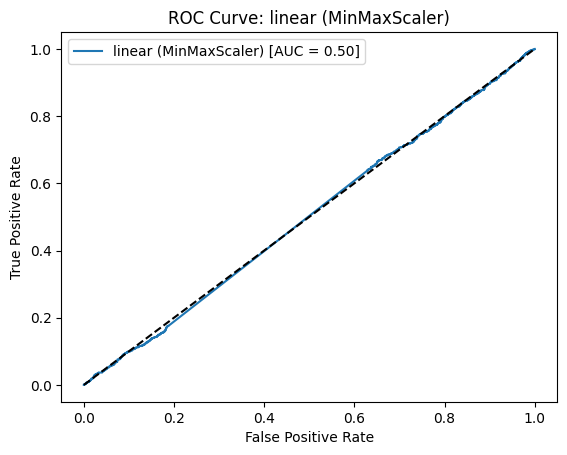


Training SVM (rbf kernel) with MinMaxScaler...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for RBF (MinMaxScaler): {'C': 10, 'gamma': 0.1}


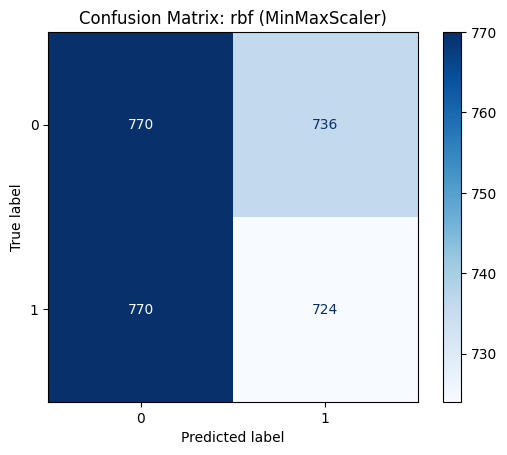

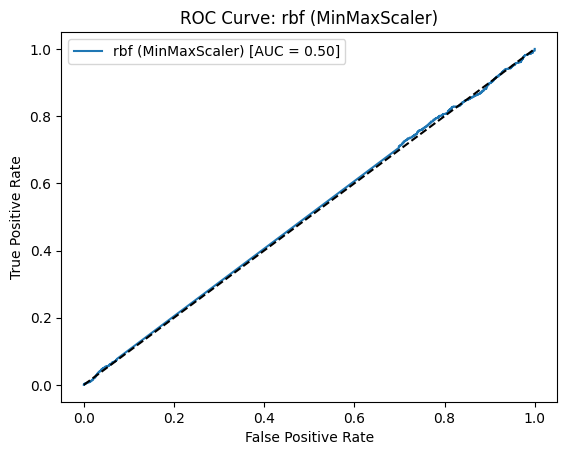

In [9]:
# Looping over each scaler and kernel
# Training the model
# Recording the metrics

for scaler_name, scaler in scalers.items():
    # Scale the data based on the current scaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for kernel in kernels:
        print(f"\nTraining SVM ({kernel} kernel) with {scaler_name}...")  # Progress message
        
        if kernel == 'linear':
            # Linear kernel: use GridSearchCV for tuning only C values (gamma not needed)
            param_grid_linear = {'C': param_grid['C']}  # Only C values
            svm = SVC(kernel='linear', probability=True, random_state=42)
            
            grid = GridSearchCV(
                estimator=svm,
                param_grid=param_grid_linear,
                scoring='f1',
                cv=3,
                n_jobs=-1
            )
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters for Linear ({scaler_name}): {grid.best_params_}")
        
        elif kernel == 'rbf':
            # RBF kernel: use full param_grid (C + gamma)
            svm = SVC(kernel='rbf', probability=True, random_state=42)
            
            grid = GridSearchCV(
                estimator=svm,
                param_grid=param_grid,
                scoring='f1',
                cv=5,
                n_jobs=-1,
                verbose=1
            )
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters for RBF ({scaler_name}): {grid.best_params_}")

        # --- Evaluate the model ---
        y_pred = best_model.predict(X_test_scaled)
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_prob)

        results.append({
            'Scaler': scaler_name,
            'Kernel': kernel,
            'Best Params': grid.best_params_,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'ROC AUC': auc_score
        })

        # --- Display the confusion matrix ---
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix: {kernel} ({scaler_name})")
        plt.show()

        # --- Plot the ROC curve ---
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{kernel} ({scaler_name}) [AUC = {auc_score:.2f}]")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {kernel} ({scaler_name})")
        plt.legend()
        plt.show()


In [10]:
#Comparing the models

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by = 'F1 Score', ascending = False)

print("\nFinal Comparison of all SVM variants: ")
display (results_df)


Final Comparison of all SVM variants: 


,Scaler,Kernel,Best Params,Accuracy,Precision,Recall,F1 Score,ROC AUC
1,StandardScaler,rbf,"{'C': 10, 'gamma': 'scale'}",0.501333,0.499329,0.497992,0.498660,0.508092
3,MinMaxScaler,rbf,"{'C': 10, 'gamma': 0.1}",0.498000,0.495890,0.484605,0.490183,0.504321
2,MinMaxScaler,linear,{'C': 1},0.503333,0.501412,0.475234,0.487973,0.498161
0,StandardScaler,linear,{'C': 1},0.502000,0.500000,0.473896,0.486598,0.498104


In [18]:
#Visualzation of Linear vs RBF Decision Boundaries

#Identifying teh best models from results_df
#Selecting top models fr each kernel witht the highest F1 score
best_linear = results_df[results_df['Kernel'] == 'linear'].iloc[0]
best_rbf = results_df[results_df['Kernel'] == 'rbf'].iloc[0]

print("Best Linear SVM:", best_linear['Scaler'])
print("Best RBF SVM:\t", best_rbf['Scaler'])

Best Linear SVM: MinMaxScaler
Best RBF SVM:	 StandardScaler


In [21]:
#Reducing to 2D using PCA for visualization
pca = PCA(n_components = 2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [24]:
#Refitting the best models on PCA data

best_models_pca = {}
for kernel in ['linear', 'rbf']:
    best_row = results_df[results_df['Kernel'] == kernel].iloc[0]
    best_models_pca[kernel] = SVC (
        kernel = kernel,
        C = best_row ['Best Params']['C'],
        gamma = best_row ['Best Params'].get('gamma', 'scale'),
        probability = True,
        random_state = 42
    ).fit(X_train_pca, y_train)

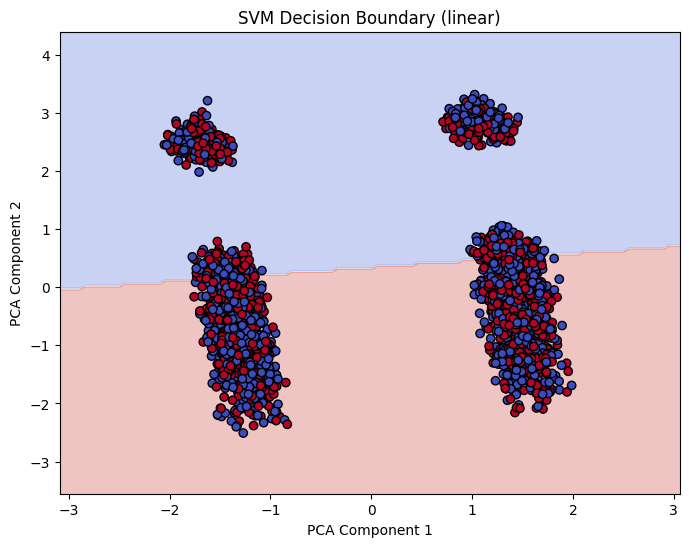

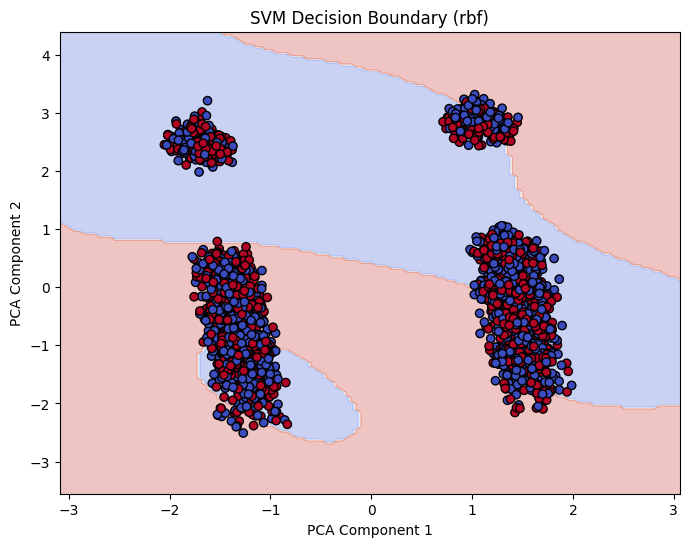

In [27]:
#Creating a meshgrid
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), 
                    np.arange(y_min, y_max, 0.05))

#Plot decission boundaries
for kernel, model in best_models_pca.items():
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize = (8,6))
    plt.contourf(xx, yy, Z, cmap = 'coolwarm', alpha = 0.3)
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c = y_test, cmap = 'coolwarm', edgecolors = 'k')
    plt.title(f"SVM Decision Boundary ({kernel})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

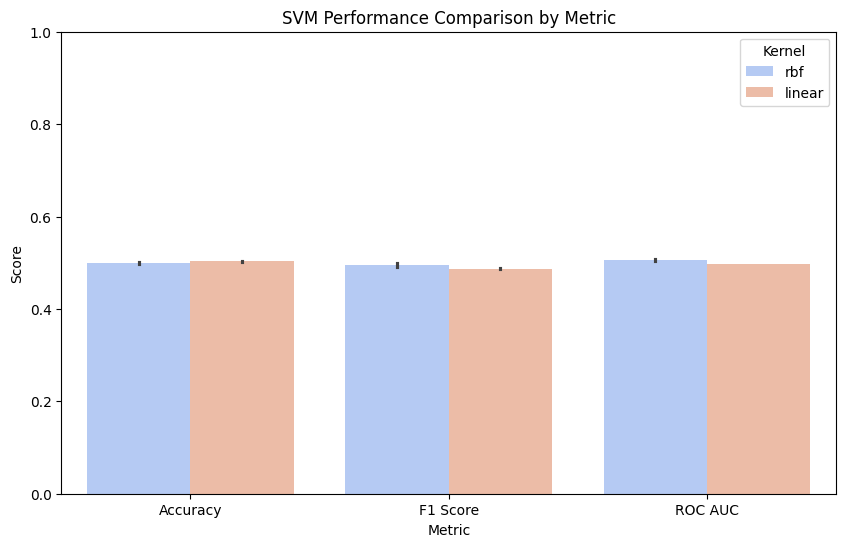

In [28]:
#Visualizing the model performance

metric_cols = ['Accuracy', 'F1 Score', 'ROC AUC']

plt.figure(figsize = (10, 6))
results_melted = results_df.melt(id_vars = ['Scaler', 'Kernel'], value_vars = metric_cols,
                                var_name = 'Metric', value_name = 'Score')
sns.barplot(data = results_melted, x = 'Metric', y = 'Score', hue = 'Kernel', palette = 'coolwarm')
plt.title("SVM Performance Comparison by Metric")
plt.ylim(0,1)
plt.legend(title = 'Kernel')
plt.show()

In [1]:
#INTERPRETATION OF RESULTS

#The performance of different Support Vector Machine (SVM) tested across 2 
#scaling techniques (StandardScaler & MinMaxScaler) & 2 kernel types (Linear & RBF)

#Across all 4 varients, all evaluation metrics used such as accuracy, precision, recall
#F1 score etc. were very close to 0.5. This suggests that the models are performing no better 
#than random guessing

#Among the 4 the StandardScaler & RBF kernel gave slightly higher ROC AOC implying it performed
#slightly better than the others

#While the SVM model were trained using the full feature set it is difficult to visualize
#high-dimensional decision borders, hence we apply PCA to show the data into 2 principal components
#PCA in this code is only used for visualization & not training or evaluation

#Final Conclusion
#The SVM model is not capturing useful patterns from the data - aka the SVM models were tested
#with different scalers & kernels... and like I am to my parents they were dissapointing
#with none of them achieving a good predictive performance